In [1]:
#Importing the libaries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#Reading the data
data=pd.read_csv('train.csv',index_col=False)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Understanding the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Checking null values
data.isnull().sum()
null_val = pd.DataFrame(round(data.isnull().sum()/len(data.index)*100,2).sort_values(ascending=False),columns=["null %"])
null_val.index.name = 'Col'
temp_df = null_val[null_val["null %"] > 0]
temp_df

,null %
Col,
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageYrBlt,5.55
GarageCond,5.55
GarageType,5.55


## Handling null and missing values

In [5]:
# Dropping columns with too many missing values
data = data.drop(['PoolQC','Id','Alley','MiscFeature','Fence','FireplaceQu'],axis=1)

In [6]:
for col in ('BsmtExposure', 'BsmtFinType2', 'BsmtFinType1','BsmtCond','BsmtQual'):
    
    data[col] = data[col].fillna(data[col].mode()[0])

data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].median())

data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['GarageYrBlt'].median())

for col in ('MasVnrArea', 'MasVnrType', 'Electrical'):
    
    data[col] = data[col].fillna(data[col].mode()[0])

for col in ('GarageCond', 'GarageType', 'GarageFinish','GarageQual'):
    
    data[col] = data[col].fillna(data[col].mode()[0])
    
data = data.drop(['PoolArea','MiscVal','3SsnPorch'],axis=1)    

data.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 72, dtype: int64

In [7]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,1978.589041,1.767123,472.980137,94.244521,46.660274,21.954110,15.060959,6.321918,2007.815753,180921.195890
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,23.997022,0.747315,213.804841,125.338794,66.256028,61.119149,55.757415,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,480.000000,12.000000,2010.000000,755000.000000


## Data Analysis

In [8]:
# Removing outliers
columns = ['MSSubClass', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath','LotFrontage', 'LotArea', 
        'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF',  'FullBath', 'HalfBath', 'BedroomAbvGr', 'ScreenPorch', 
        'MoSold', 'YrSold','KitchenAbvGr',  'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch',
        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'SalePrice']

quan1 = data[columns].quantile(0.05)
quan2 = data[columns].quantile(0.95)
q = quan2 - quan1

data = data[~((data[columns] < (quan1 - 1.5 * q)) |(data[columns] > (quan2 + 1.5 * q))).any(axis=1)]

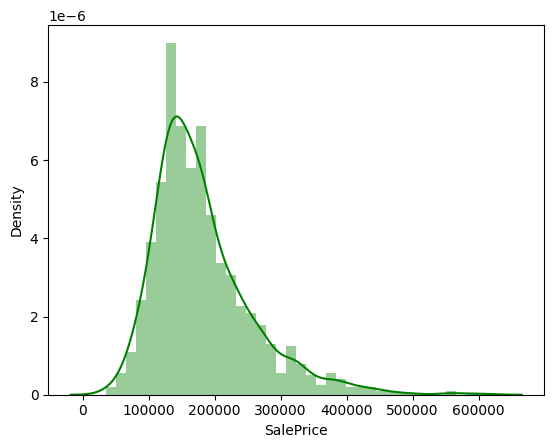

In [9]:
# Visualise sale price
plt.figure()
sns.distplot(data['SalePrice'],color='g')
plt.show()

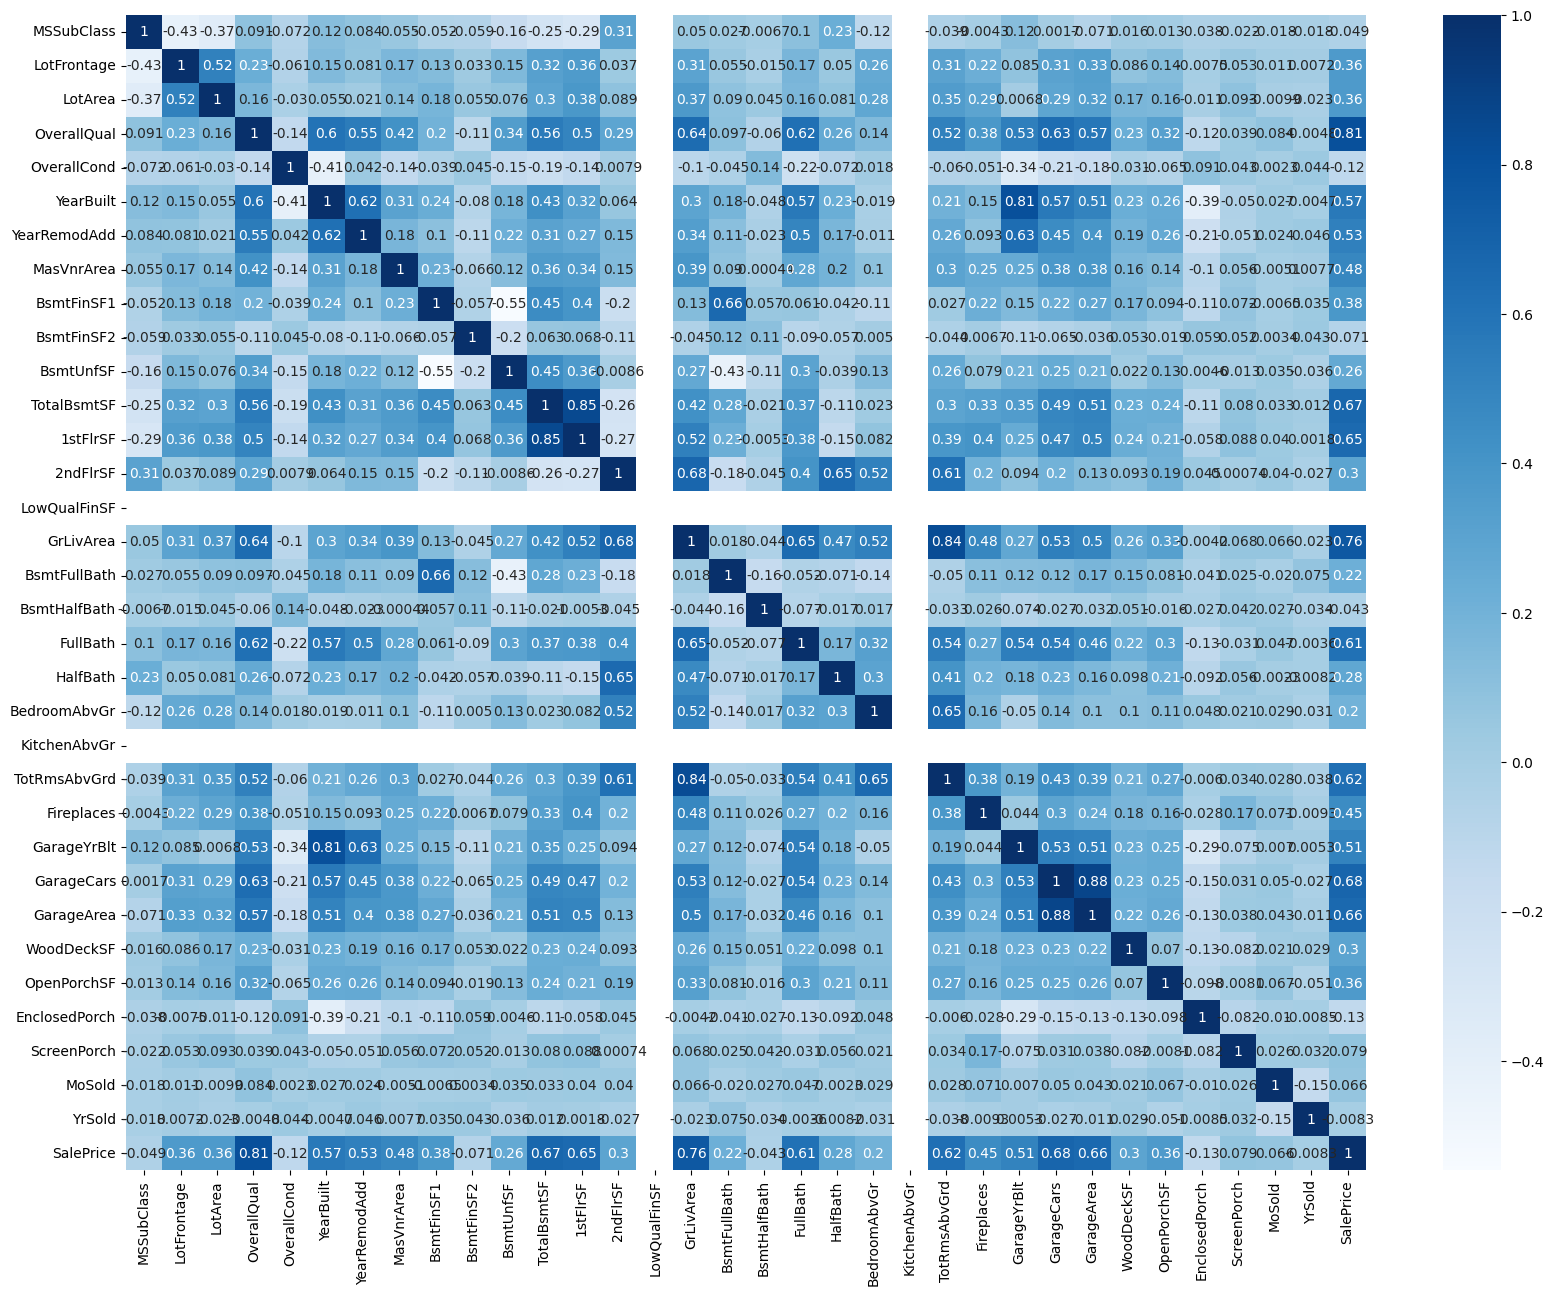

In [10]:
# Checking correlation betweeen variables
plt.figure(figsize = (20, 15))
sns.heatmap(data.corr(), annot = True, cmap="Blues")
plt.show()

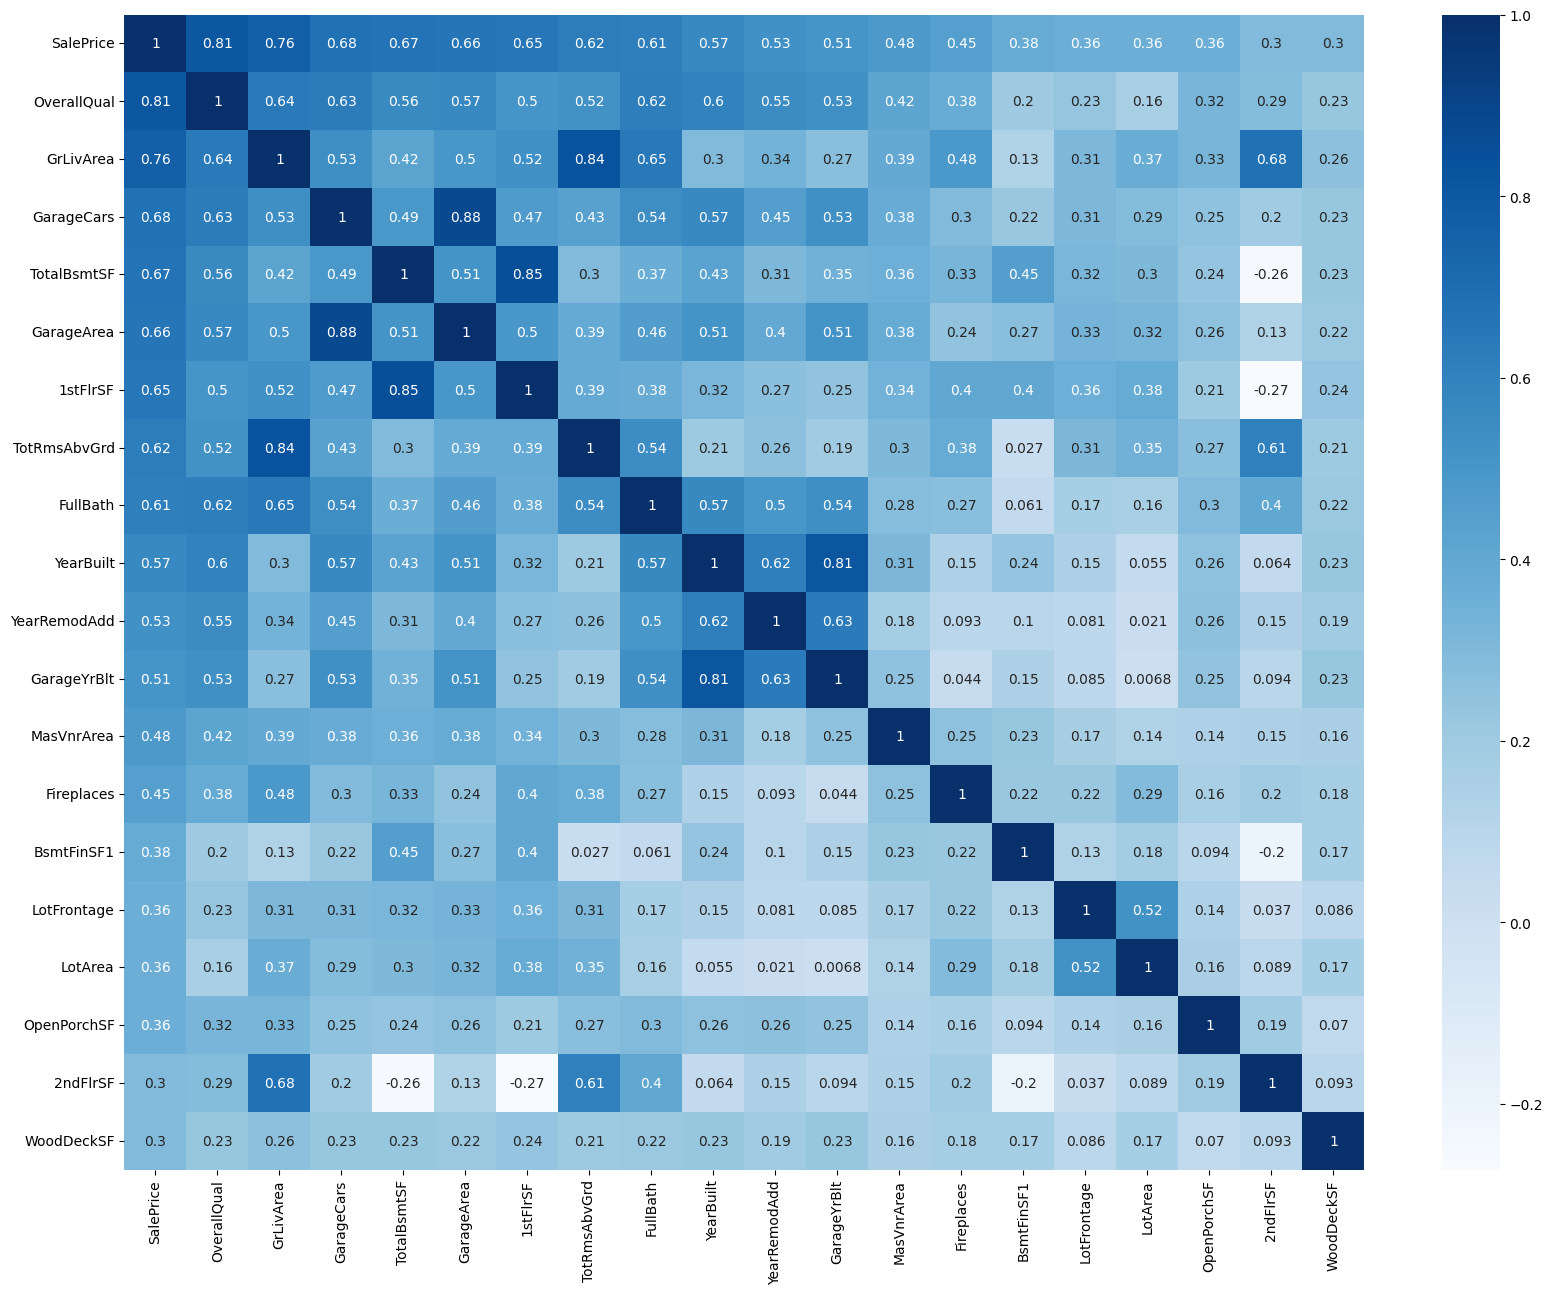

In [11]:
# Correlation of variables with Sales
plt.figure(figsize = (20, 15))
n = 20
cor = data.corr()
columns = cor.nlargest(n, 'SalePrice')['SalePrice'].index
sns.heatmap(data[columns].corr(),annot=True, cmap="Blues")
plt.show()


## Handle Categorical variables

In [12]:
# Convert categorical value into Dummy variable
data=pd.get_dummies(data,drop_first=True)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


## Splitting the data into train and test

In [13]:
#Split the data into train and test
y = data.pop('SalePrice')
X = data

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

## Scaling the numerical variables

In [15]:
numerical_vars= ['MSSubClass', 'LotFrontage', 'LotArea','OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold', 'OverallQual', 'OverallCond', 'YearBuilt', 
           'YearRemodAdd', 'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
           'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','Fireplaces', 'GarageYrBlt', 
           'WoodDeckSF',  'YrSold','GarageCars', 'GarageArea',]

from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler=MinMaxScaler()
X_train[numerical_vars] = scaler.fit_transform(X_train[numerical_vars])
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])

In [16]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,...,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000
mean,0.206639,0.299868,0.238826,0.576158,0.510488,0.732079,0.602019,0.096948,0.233302,0.040094,...,0.003215,0.005359,0.092176,0.001072,0.860665,0.002144,0.003215,0.013934,0.817792,0.095391
std,0.238350,0.123225,0.117819,0.149573,0.154933,0.217608,0.341110,0.160493,0.224042,0.138686,...,0.056644,0.073048,0.289429,0.032739,0.346482,0.046274,0.056644,0.117278,0.386223,0.293912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.242236,0.176136,0.444444,0.428571,0.600000,0.300000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.176471,0.298137,0.231222,0.555556,0.428571,0.748148,0.750000,0.000000,0.209559,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.235294,0.354037,0.293892,0.666667,0.571429,0.948148,0.900000,0.158548,0.384979,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building and evaluating models

### 1. RFE

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)
rfe =  RFE(model, n_features_to_select=25)  
rfe = rfe.fit(X_train, y_train)

In [18]:
#Top features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))
col = X_train.columns[rfe.support_]
col


Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'Street_Pave', 'LandSlope_Sev',
       'HouseStyle_2.5Fin', 'RoofStyle_Shed', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl', 'Foundation_Slab', 'Foundation_Wood', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_TA', 'Functional_Sev', 'SaleType_Oth'],
      dtype='object')

In [19]:
model1=model.fit(X_train, y_train)

In [20]:
X_train1=X_train[col]
X_test1=X_test[col]

y_pred_train = rfe.predict(X_train)
y_pred_test = rfe.predict(X_test)

In [21]:
train_lr = r2_score(y_train, y_pred_train)
print(train_lr)

test_lr = r2_score(y_test, y_pred_test)
print(test_lr)


0.8948282699853886
0.8586554847941028


### 2. Ridge Regression

In [22]:
params = {'alpha': [ 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500 ]}

ridge = Ridge()

folds = 10
ridge_model = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model.fit(X_train1, y_train) 

Fitting 10 folds for each of 26 candidates, totalling 260 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100,
                                   500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [23]:
print(ridge_model.best_params_)
print(ridge_model.best_score_)

{'alpha': 2.0}
-17517.153274420947


In [24]:
alpha = 2
ridge = Ridge(alpha=alpha)
ridge.fit(X_train1, y_train)

y_pred_train = ridge.predict(X_train1)
y_pred_test = ridge.predict(X_test1)

In [25]:
train_rg = r2_score(y_train, y_pred_train)
print(train_rg)

test_rg = r2_score(y_test, y_pred_test)
print(test_rg)

0.8903685137408511
0.8681907743530571


## 3. Lasso

In [26]:
lasso = Lasso()

folds=10
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train1, y_train)

Fitting 10 folds for each of 26 candidates, totalling 260 fits


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100,
                                   500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [27]:
print(lasso_model_cv.best_params_)

{'alpha': 50}


In [28]:
alpha =50
lasso = Lasso(alpha=alpha)       
lasso.fit(X_train1, y_train) 
y_pred_train = lasso.predict(X_train1)
y_pred_test = lasso.predict(X_test1)

In [29]:
train_ls = r2_score(y_train, y_pred_train)
print(train_ls)

test_ls = r2_score(y_test, y_pred_test)
print(test_ls)

0.891199503771867
0.8695023941484784


In [68]:
print('Linear regression: ','Train r2:', round(train_lr,3),'Test r2:',round(test_lr,3))
print('Ridge  regression: ','Train r2:', round(train_rg,3),'Test r2:',round(test_rg,3))
print('Lasso  regression: ','Train r2:', round(train_ls,3),'Test r2:',round(test_ls,3))

Linear regression:  Train r2: 0.895 Test r2: 0.859
Ridge  regression:  Train r2: 0.89 Test r2: 0.868
Lasso  regression:  Train r2: 0.891 Test r2: 0.87


In [69]:
imp_beta = pd.DataFrame(index=X_train1.columns)
imp_beta.rows = X_train1.columns
imp_beta['Ridge'] = ridge.coef_
imp_beta['Lasso'] = lasso.coef_
imp_beta

,Ridge,Lasso
LotArea,44082.356396,45531.814301
OverallQual,101219.799978,108409.497911
OverallCond,38226.515740,40253.503758
YearBuilt,43360.180896,43262.989003
BsmtFinSF1,35776.388114,33277.272893
TotalBsmtSF,87817.485940,101478.081065
1stFlrSF,72229.047580,0.000000
2ndFlrSF,46846.315252,5554.621785
GrLivArea,93129.935051,179208.590536
BedroomAbvGr,-38421.810724,-44498.878716


#### Ques 1: Which variables are significant in predicting the price of a house

#### Ans 1:

1. LotArea (Lot size in square feet)
2. OverallQual (Rates the overall material and finish of the house)
3. OverallCond (Rates the overall condition of the house)
4. YearBuilt (Original construction date)
5. Basement floor related variables
6. GrLivArea (Above grade (ground) living area square feet)
7. TotRmsAbvGrd (Total rooms above grade (does not include bathrooms))
8. GarageCars (Size of garage in car capacity)


#### Ques 2: How well those variables describe the price of a house

Ridge  regression:  Train r2: 0.89 Test r2: 0.868


Lasso  regression:  Train r2: 0.891 Test r2: 0.87

# Problem Statement 2

***Question 1***: What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

***Answer 1:***

In [70]:
# Doubling alpha for Ridge Regression

alpha = 4
ridge2 = Ridge(alpha=alpha)
ridge2.fit(X_train1, y_train)

y_pred_train = ridge2.predict(X_train1)
y_pred_test = ridge2.predict(X_test1)

r2_train_rg = r2_score(y_train, y_pred_train)
print('Ridge train r2:',r2_train_rg)

r2_test_rg = r2_score(y_test, y_pred_test)
print('Ridge test r2:',r2_test_rg)

Ridge train r2: 0.8863020351786519
Ridge test r2: 0.8658961181909242


In [71]:
# Doubling alpha for Lasso Regression

alpha =100
lasso20 = Lasso(alpha=alpha)
lasso20.fit(X_train1, y_train) 
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso20.predict(X_train1)
y_pred_test = lasso20.predict(X_test1)

metric3 = []
r2_train_ls = r2_score(y_train, y_pred_train)
print('Lasso train r2:',r2_train_ls)

r2_test_ls = r2_score(y_test, y_pred_test)
print('Lasso test r2:',r2_test_ls)

Lasso train r2: 0.8876692764313839
Lasso test r2: 0.8683327746966043


#### r2score of training data has decreased slightly for both ridge and lasso regression

In [72]:
#Important variables
imp_var = pd.DataFrame(index=X_train1.columns)
imp_var.rows = X_train1.columns
imp_var['Ridge'] = ridge.coef_
imp_var['Ridge2'] = ridge2.coef_
imp_var['Lasso'] = lasso.coef_
imp_var['Lasso2'] = lasso20.coef_
imp_var

,Ridge,Ridge2,Lasso,Lasso2
LotArea,44082.356396,39619.849180,45531.814301,37229.962834
OverallQual,101219.799978,96280.665169,108409.497911,112207.662478
OverallCond,38226.515740,33410.530746,40253.503758,35868.503623
YearBuilt,43360.180896,43278.031243,43262.989003,42054.320159
BsmtFinSF1,35776.388114,37128.060402,33277.272893,33756.618649
TotalBsmtSF,87817.485940,77501.237152,101478.081065,92970.995865
1stFlrSF,72229.047580,70232.315784,0.000000,0.000000
2ndFlrSF,46846.315252,42099.067029,5554.621785,0.000000
GrLivArea,93129.935051,88568.669116,179208.590536,183009.423042
BedroomAbvGr,-38421.810724,-27247.490651,-44498.878716,-31665.929044


### It gives the same variables as important features but with different coefficients

***Question 3*** After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

***Answer 3*** Top 5 features are LotArea, OverallQual, GarageCars, YearBuilt, TotalBsmtSF

In [73]:
X_train2 = X_train1.drop(['LotArea','OverallQual','YearBuilt','GarageCars','TotalBsmtSF'],axis=1)
X_test2 = X_test1.drop(['LotArea','OverallQual','YearBuilt','GarageCars','TotalBsmtSF'],axis=1)

In [74]:
alpha =50
lasso21 = Lasso(alpha=alpha)
lasso21.fit(X_train2, y_train) 

# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso21.predict(X_train2)
y_pred_test = lasso21.predict(X_test2)

metric3 = []
r2_train_ls = r2_score(y_train, y_pred_train)
print(r2_train_ls)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_ls)

0.8393868515334029
0.8683327746966043


### There is a drop in r2 score for both train and test sets

In [75]:
#Important variables
imp_var = pd.DataFrame(index=X_train2.columns)
imp_var.rows = X_train1.columns
imp_var['Lasso_new'] = lasso21.coef_
pd.set_option('display.max_rows', None)
imp_var.sort_values(by=['Lasso_new'], ascending=False)

,Lasso_new
GrLivArea,229928.003996
1stFlrSF,107177.063658
TotRmsAbvGrd,60344.434908
BsmtFinSF1,41916.573229
OverallCond,31183.105990
RoofStyle_Shed,13047.687983
Street_Pave,1841.136500
LandSlope_Sev,-0.000000
2ndFlrSF,0.000000
Foundation_Slab,0.000000


#### Top 5 variables after removing LotArea, OverallQual, GarageCars, YearBuilt, TotalBsmtSF

1. GrLivArea (Above grade (ground) living area square feet)
2. Street_Pave (Pave road access to property)
3. 11stFlrSF (First Floor square feet)
4. BsmtFinSF1 (Type 1 finished square feet)
5. RoofMatl_Metal (Roof material_Metal)
